# Ensemble Visualisation

This just installs a few libraries.

In [4]:
# !conda install boto3 -y
# !conda install -c scitools/label/dev -c conda-forge iris cartopy -y
# !conda install -c conda-forge -c ioam holoviews geoviews -y
# !conda upgrade -y holoviews

In [13]:
import boto3
import tempfile
import pickle
import operator
import functools as fp

import holoviews as hv
import geoviews as gv

from cartopy import crs
from cartopy import feature as cf
from geoviews import feature as gf

hv.notebook_extension('matplotlib')

We'll load some canned data from an S3 bucket and unpickle it

In [6]:
client = boto3.client('s3')
temp = tempfile.NamedTemporaryFile()
client.download_file('mogreps-pickles', 'demo_mogreps', temp.name)
with open(temp.name, 'rb') as pickle_file:
    cube = pickle.load(pickle_file)

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.credentials:Found credentials from IAM Role: jade-secrets
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): mogreps-pickles.s3.amazonaws.com


Now we have an iris cube containing relative humidity data for 33 ensemble members.

In [7]:
print(cube)

relative_humidity / (%)             (realization: 33; latitude: 100; longitude: 66)
     Dimension coordinates:
          realization                           x             -               -
          latitude                              -             x               -
          longitude                             -             -               x
     Scalar coordinates:
          forecast_period: 0.0 hours
          forecast_reference_time: 2016-08-25 00:00:00
          pressure: 100.0 hPa
          time: 2016-08-25 00:00:00
     Attributes:
          STASH: m01s16i256
          source: Data from Met Office Unified Model
          um_version: 10.2


Geoviews can load data straight from iris. We just need to name the dimensions.

In [11]:
xr_dataset = gv.Dataset(cube, crs=crs.PlateCarree(), 
                        kdims=['realization','latitude','longitude'],
                        vdims=['relative_humidity'])

## Postage stamps

Now that we have a geoviews dataset, we can convert the lat-long slices into images. 

/opt/conda/envs/py34/lib/python3.4/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


b':NdLayout   [realization]\n   :Overlay\n      .Relative_humidity.I :Image   [longitude,latitude]   (relative_humidity)\n      .Coastline.I         :Feature   [Longitude,Latitude]'
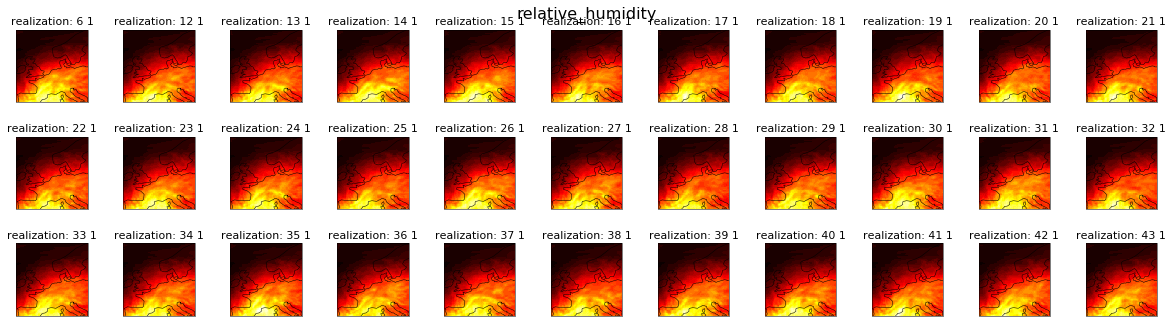

In [14]:
%output size=40
rel_hum = xr_dataset.to(gv.Image, ['longitude', 'latitude']) * gf.coastline
rel_hum.layout().cols(11)

## Or show just one at a time...

## (and we'll throw in a histogram for good measure)

If we don't specify how the dataset should be displayed, geoviews will make an educated guess.

In [ ]:
%output size=150
rel_hum

It also comes with some helper methods. This one adds a histogram of the values in each realization.

In [ ]:
rel_hum.hist()

## Spagetti plots!

## One at a time...

As well as displaying a raster image, we can use other such as contour lines.

In [ ]:
xr_dataset.to(gv.LineContours, ['longitude', 'latitude']) * gf.coastline


## ...or all together

Instead of converting the entire cube to one dataset, we could choose to slice it into a list of datasets.

In [ ]:
members_dataset = [gv.Dataset(c, crs=crs.PlateCarree(), 
                        kdims=['longitude','latitude'],
                        vdims=['relative_humidity']) for c in cube.slices_over('realization')]
contours = [c.to(gv.LineContours,
                        kdims=['longitude','latitude'],
                        vdims=['relative_humidity']) for c in members_dataset]

Addition has been overloaded to display plots side by side.

In [ ]:
contours[0] + contours[1] + contours[2]

Likewise, multiplication is used to layer plots on top of one another.

In [ ]:
contours[3] * contours[4]

Using a bit of functional programming, we can layer all the contours into a kind of spaghetti plot.

In [ ]:
fp.reduce(operator.mul, contours) * gf.coastline

## We can dig down further.

## Let's see the spread at each point with a scatter plot

We can get an idea of the uncertainty at each point by seeing how well the realizations agree.

In [ ]:
xr_dataset.to(hv.Scatter, ['realization'], dynamic=True)

## ...and aggregate over each latitude

The box plot shows the spread of values across each latitude. This could be more enlightening if we had a time dimension as well as one for realization.

In [ ]:
%%opts BoxWhisker [xrotation=25 bgcolor='w']
xr_dataset.to.box('realization', mdims=['latitude'], dynamic=True)